In [408]:
#Importa librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import pickle  



DATA COLLECTION

Datos de Yahoo Finance

In [409]:
sp500 = yf.Ticker("^GSPC")
gold = yf.Ticker("^GC=F")
oil= yf.Ticker("CL=F")
brent= yf.Ticker("BZ=F")

Para el Sp500 utilizo los datos a partir del año 2000, ya que en años anteriores la composición por industria del SP500 era bastante diferente. A partir de ese año hay importnate participación del sector teconología. Hago lo mismo para las otras variables

In [410]:
start_date = '2000-01-01'
end_date = '2024-04-26'

sp500 = sp500.history(period="max")
sp500 =sp500.loc[start_date:end_date].copy ()
oil = oil.history(period="max")
oil = oil.loc[start_date:end_date].copy ()
brent = brent.history(period="max") 
brent = brent.loc[start_date:end_date:].copy ()


In [411]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0


In [412]:
sp500 = sp500.drop(columns=['Dividends', 'Stock Splits'])
sp500.index= sp500.index.tz_localize(None) # remove timezone

In [413]:
#Guardar el dataset en un archivo csv   
sp500.to_csv('sp500.csv', index=True)

In [414]:
#Hago lo mismo con el resto de los activos
oil = oil.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Volume'])
oil.index= oil.index.tz_localize(None) # remove timezone
oil.head()

,Close
Date,
2000-08-23,32.049999
2000-08-24,31.629999
2000-08-25,32.049999
2000-08-28,32.869999
2000-08-29,32.720001


In [415]:
# Renombo la columna 'Close' a 'Close_oil' en el DataFrame 'oil' para que no se confunda con la del S&P 500
oil.rename(columns={'Close': 'Close_oil'}, inplace=True)

# Muestra las primeras filas para verificar el cambio
print(oil.head())


            Close_oil
Date                 
2000-08-23  32.049999
2000-08-24  31.629999
2000-08-25  32.049999
2000-08-28  32.869999
2000-08-29  32.720001


In [416]:
# Asumiendo que 'df' es tu DataFrame y 'oil' es la columna con los datos de precios de petróleo
oil['oil_daily_changes'] = oil['Close_oil'].pct_change() * 100  # Multiplicar por 100 para convertir a porcentaje


Datos de FRED (Banco de la Reserva Federal de St. Louis)

In [417]:
import requests


# FRED API endpoint
url = "https://api.stlouisfed.org/fred/series/observations"

# List of series IDs to be downloaded
# CREDIT RISK AND RISK APPETITE VARIABLES # OJO --->>>> Estas variables miden el riesgo de crédito y el apetito por el riesgo de los inversores 

# DAAA = Moody's Seasoned Aaa Corporate Bond Yield
# AAA10Y = Moody's Seasoned Aaa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# DBAA = Moody's Seasoned Baa Corporate Bond Yield
# BAA10Y = Moody's Seasoned Baa Corporate Bond Yield Relative to Yield on 10-Year Treasury Constant Maturity
# BAMLH0A0HYM2 = ICE BofA US High Yield Index Option-Adjusted Spread 
# BAMLH0A2HYB = ICE BofA Single-B US High Yield Index Option-Adjusted Spread 
# BAMLH0A3HYC = ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread
# BAMLHE00EHYIOAS = ICE BofA Euro High Yield Index Option-Adjusted Spread -  

# INTEREST RATE VARIABLES
#OJO --->>>> Esta variables miden el cambio en las expectativas de inflación y los movimientos de tasas de interés

# T10Y2Y = 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
# T10Y3M = 10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity  
# T5YIE = 5-Year Breakeven Inflation Rate (Expected Inflation Rate) - 5-Year 

# EXCHANGE RATES Vs main commercial partners for the U.S.
# DEXUSEU = U.S. Dollars to Euro Spot Exchange Rate - value of one U.S. Dollar in Euros
# DEXCHUS = Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate - value of one Chinese Yuan Renminbi in U.S. Dollars
# DEXCAUS = Canadian Dollars to U.S. Dollar Spot Exchange Rate - value of one Canadian Dollar in U.S. Dollars
# DEXMXUS= Mexican Pesos to U.S. Dollar Spot Exchange Rate - value of one Mexican Peso in U.S. Dollars

# VOLATILITY INDECES (MARKET EXPECTATION OF NEAR TERM VOLATILITY)
# VIXCLS = CBOE Volatility Index - VIX measures market expectation of near term volatility conveyed by stock index option prices.
#(GVZCLS)= CBOE Gold ETF Volatility Index 

series_ids = ['DAAA','AAA10Y','DBAA','BAA10Y','BAMLH0A0HYM2','BAMLH0A2HYB','BAMLH0A3HYC','BAMLHE00EHYIOAS','T10Y2Y','T10Y3M','T5YIE','DEXUSEU','DEXCHUS','DEXCAUS','DEXMXUS','VIXCLS','GVZCLS']

# Your FRED API key
api_key = '7de04d83472c6affd4e0a1505211d3b9'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through each series ID
for series_id in series_ids:
    # API parameters
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the response to JSON
        data = response.json()
        # Extract data for DataFrame
        dates = [item['date'] for item in data['observations']]
        values = [item['value'] for item in data['observations']]
        # Create DataFrame and convert types
        temp_df = pd.DataFrame({'Date': dates, series_id: values})
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        temp_df[series_id] = pd.to_numeric(temp_df[series_id], errors='coerce')
        # Add the DataFrame to the dictionary
        dfs[series_id] = temp_df.set_index('Date')
    else:
        print(f"Failed to retrieve data for {series_id}: {response.status_code}")

# Combine all the series DataFrames into one DataFrame 
macroeconomic_df = pd.concat(dfs.values(), axis=1)




In [418]:
#Sacar los cambios diarios de las variables macroeconomicas
changes_daily = macroeconomic_df.diff()

# Renombrar las columnas para indicar que representan cambios diarios
changes_daily.columns = [f"{col}_daily_change" for col in macroeconomic_df.columns]

# Concatenar los cambios diarios de vuelta al DataFrame original
macroeconomic_df = pd.concat([macroeconomic_df, changes_daily], axis=1)

In [419]:
# Contar los valores nulos en cada columna
null_counts_macro = macroeconomic_df.isnull().sum()
print("Conteo de valores nulos por columna antes de limpiar:\n", null_counts_macro)

# Eliminar las filas con valores nulos o NaN
macroeconomic_df_clean = macroeconomic_df.dropna()

# Contar de nuevo los valores nulos en cada columna
null_counts_clean = macroeconomic_df_clean.isnull().sum()
print("Conteo de valores nulos por columna después de limpiar:\n", null_counts_clean)

# Guardar el DataFrame limpio a un archivo CSV
macroeconomic_df_clean.to_csv("macroeconomic_df_clean.csv")


Conteo de valores nulos por columna antes de limpiar:
 DAAA                             3626
AAA10Y                           3674
DBAA                             4385
BAA10Y                           4421
BAMLH0A0HYM2                     6871
BAMLH0A2HYB                      6871
BAMLH0A3HYC                      6871
BAMLHE00EHYIOAS                  7128
T10Y2Y                           2028
T10Y3M                           3419
T5YIE                            8667
DEXUSEU                          7656
DEXCHUS                          3195
DEXCAUS                           629
DEXMXUS                          6367
VIXCLS                           5345
GVZCLS                           9998
DAAA_daily_change                4102
AAA10Y_daily_change              4198
DBAA_daily_change                4837
BAA10Y_daily_change              4909
BAMLH0A0HYM2_daily_change        6959
BAMLH0A2HYB_daily_change         6959
BAMLH0A3HYC_daily_change         6959
BAMLHE00EHYIOAS_daily_change     

In [420]:
# Unir macroeconomic_df con sp500 basado en sus índices de fecha
AllVar_df =sp500.join(macroeconomic_df_clean, how='inner')

print(AllVar_df.index)
AllVar_df = AllVar_df.sort_index()

DatetimeIndex(['2008-06-04', '2008-06-05', '2008-06-06', '2008-06-09',
               '2008-06-10', '2008-06-11', '2008-06-12', '2008-06-13',
               '2008-06-16', '2008-06-17',
               ...
               '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
               '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17',
               '2024-04-18', '2024-04-19'],
              dtype='datetime64[ns]', name='Date', length=3727, freq=None)


In [421]:
# Unir el DataFrame 'oil' al 'AllVar_df' que ya contiene datos combinados de 'macroeconomic_df' y 'sp500'
# Asegúrate de que 'oil' está indexado adecuadamente, si es necesario
if 'Date' in oil.columns:
    oil.set_index('Date', inplace=True)

# Especificando sufijos para resolver el conflicto de nombres de columnas
AllVar_df = AllVar_df.join(oil, how='inner', lsuffix='_AllVar', rsuffix='_oil')

# Mostrar las primeras filas para verificar las nuevas columnas
print(AllVar_df.head())

                   Open         High          Low        Close      Volume  \
Date                                                                         
2008-06-04  1376.260010  1388.180054  1371.739990  1377.199951  4338640000   
2008-06-05  1377.479980  1404.050049  1377.479980  1404.050049  4350790000   
2008-06-06  1400.060059  1400.060059  1359.900024  1360.680054  4771660000   
2008-06-09  1360.829956  1370.630005  1350.619995  1361.760010  4404570000   
2008-06-10  1358.979980  1366.839966  1351.560059  1358.439941  4635070000   

            DAAA  AAA10Y  DBAA  BAA10Y  BAMLH0A0HYM2  ...  \
Date                                                  ...   
2008-06-04  5.64    1.66  7.02    3.04          6.79  ...   
2008-06-05  5.69    1.63  7.07    3.01          6.63  ...   
2008-06-06  5.61    1.67  6.98    3.04          6.68  ...   
2008-06-09  5.58    1.56  6.96    2.94          6.58  ...   
2008-06-10  5.66    1.55  7.05    2.94          6.49  ...   

            T10Y3M_daily_

AUTOARIMA

<Axes: xlabel='Date'>

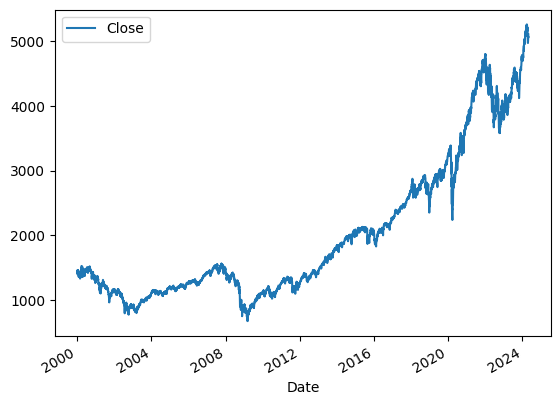

In [422]:
#Se eliminan las columnas que no se van a utilizar
# Crear un nuevo DataFrame seleccionando solo las columnas 'Date' y 'Close'
sp500_ARIMA = sp500.iloc[:, [3]]
sp500_ARIMA.plot(y="Close", use_index=True)

In [423]:
sp500_ARIMA = sp500_ARIMA.loc[start_date_All:]#ya que al juntar todos los datos para SARIMAX que implemento luego empiezan en esa fecha
sp500_ARIMA.head()

,Close
Date,
2008-06-04,1377.199951
2008-06-05,1404.050049
2008-06-06,1360.680054
2008-06-09,1361.760010
2008-06-10,1358.439941


In [424]:
#Verificar si hay valores nulos
missing_values = sp500_ARIMA.isnull().sum()
print(missing_values)

Close    0
dtype: int64


In [425]:
#Guardar el dataset en un archivo csv   
sp500_ARIMA.to_csv('sp500_yahoo2000.csv', index=True)

In [426]:
# Se convierte el índice a tipo datetime
sp500_ARIMA.index = pd.to_datetime(sp500_ARIMA.index)
# Asegurar que el índice esté en formato de fecha y ordenado
sp500_ARIMA.sort_index(inplace=True)


In [427]:
# Preparación de los datos
train_size_arima1 = int(len(sp500_ARIMA) * 0.8)
train_arima1, test_arima1 = sp500_ARIMA['Close'][:train_size_arima1], sp500_ARIMA['Close'][train_size_arima1:]


In [428]:
# Ajustar el modelo AutoARIMA
model_arima1 = auto_arima(train_arima1, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_arima1, open('ARIMA1_Close_best_model.pkl', 'wb'))
print("Mejor modelo ARIMA1 guardado:")
print(model_arima1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29464.285, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29591.287, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29490.499, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29507.420, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29592.581, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29465.740, Time=0.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29471.193, Time=0.60 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29347.728, Time=2.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29397.011, Time=2.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=29392.398, Time=4.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29455.918, Time=3.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29458.295, Time=3.75 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=29389.516, Time=3.32 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=29351.164, Time=5.62 sec
 ARIMA(3,1,2)(0,0,0

In [330]:
# Predicciones: asumimos que test_arima1 es el conjunto de datos para validar el modelo
n_periods = len(test_arima1)
predicted_values_arima1 = model_arima1.predict(n_periods=n_periods)
predicted_values_array_arima1 = np.array(predicted_values_arima1)

c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [331]:
# Crear y guardar DataFrame con resultados
test_df_arima1 = pd.DataFrame({
    'Fecha_ARIMA1': pd.to_datetime(sp500_ARIMA.index[train_size_arima1:]),
    'Valor_Real_ARIMA1': test_arima1,
    'Prediccion_ARIMA1': predicted_values_array_arima1
})
test_df_arima1.to_csv('ARIMA1_test_vs_predicciones.csv', index=False)

# Opcional: guardar solo los valores reales para comparar posteriormente
valores_reales_df_arima1 = test_df_arima1[['Fecha_ARIMA1', 'Valor_Real_ARIMA1']]
valores_reales_df_arima1.to_csv('ARIMA1_valores_reales_test.csv', index=False)


In [332]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima1 = mean_squared_error(test_arima1, predicted_values_array_arima1)
rmse_test_arima1 = np.sqrt(mse_test_arima1)
mae_test_arima1 = mean_absolute_error(test_arima1, predicted_values_array_arima1)

print(f'ARIMA1 Test - MSE: {mse_test_arima1}, RMSE: {rmse_test_arima1}, MAE: {mae_test_arima1}')

ARIMA1 Test - MSE: 118386.42575036186, RMSE: 344.073285435475, MAE: 291.4053201631565


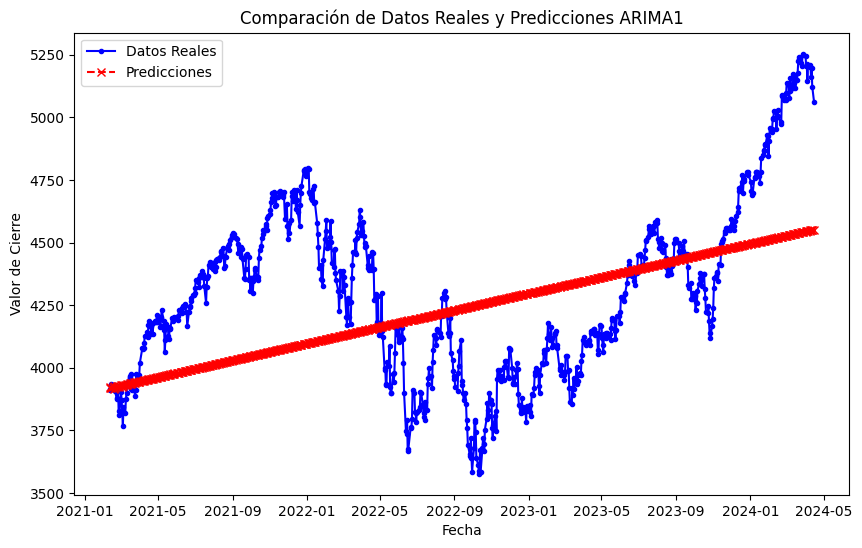

In [333]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Valor_Real_ARIMA1'], label='Datos Reales', marker='.', color='blue')
plt.plot(test_df_arima1['Fecha_ARIMA1'], test_df_arima1['Prediccion_ARIMA1'], label='Predicciones', marker='x', linestyle='--', color='red')
plt.title('Comparación de Datos Reales y Predicciones ARIMA1')
plt.xlabel('Fecha')
plt.ylabel('Valor de Cierre')
plt.legend()
plt.show()

Intentamos correr un SARIMAX, a ver si las vriables exogenas agregan poder de prediccion

In [288]:
null_counts = AllVar_df.isnull().sum()
print("Conteo de valores nulos por columna:\n", null_counts)

start_date_All = AllVar_df.index.min()
end_date_All = AllVar_df.index.max()
print(f"Los datos comienzan el: {start_date_All}")
print(f"Los datos terminan el: {end_date_All}")

Conteo de valores nulos por columna:
 Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
DAAA                            0
AAA10Y                          0
DBAA                            0
BAA10Y                          0
BAMLH0A0HYM2                    0
BAMLH0A2HYB                     0
BAMLH0A3HYC                     0
BAMLHE00EHYIOAS                 0
T10Y2Y                          0
T10Y3M                          0
T5YIE                           0
DEXUSEU                         0
DEXCHUS                         0
DEXCAUS                         0
DEXMXUS                         0
VIXCLS                          0
GVZCLS                          0
DAAA_daily_change               0
AAA10Y_daily_change             0
DBAA_daily_change               0
BAA10Y_daily_change             0
BAMLH0A0HYM2_daily_change       0
BAMLH0A2HYB_daily_change        0
BAMLH0A3HY

In [289]:
# Obtén una lista con todos los nombres de las columnas en el DataFrame
column_names = AllVar_df.columns.tolist()
print("Nombres de columnas en AllVar_df:", column_names)


Nombres de columnas en AllVar_df: ['Open', 'High', 'Low', 'Close', 'Volume', 'DAAA', 'AAA10Y', 'DBAA', 'BAA10Y', 'BAMLH0A0HYM2', 'BAMLH0A2HYB', 'BAMLH0A3HYC', 'BAMLHE00EHYIOAS', 'T10Y2Y', 'T10Y3M', 'T5YIE', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS', 'DEXMXUS', 'VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'VIXCLS_daily_change', 'GVZCLS_daily_change', 'Close_oil', 'oil_daily_changes']


In [290]:
#Seleccionar las columnas que se van a utilizar
selected_columns = ['VIXCLS', 'GVZCLS', 'DAAA_daily_change', 'AAA10Y_daily_change', 'DBAA_daily_change', 'BAA10Y_daily_change', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change', 'BAMLH0A3HYC_daily_change', 'BAMLHE00EHYIOAS_daily_change', 'T10Y2Y_daily_change', 'T10Y3M_daily_change', 'T5YIE_daily_change', 'DEXUSEU_daily_change', 'DEXCHUS_daily_change', 'DEXCAUS_daily_change', 'DEXMXUS_daily_change', 'oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1 = AllVar_df[selected_columns]

y_arimax1= AllVar_df['Close']

In [291]:
# Se convierte el índice a tipo datetime
X_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1.sort_index(inplace=True)

In [292]:
# Se convierte el índice a tipo datetime
y_arimax1.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1.sort_index(inplace=True)

In [293]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1 = int(len(AllVar_df) * 0.8)
y_train_arimax1 = y.iloc[:train_size_arimax1]
X_train_arimax1 = X.iloc[:train_size_arimax1]

y_test_arimax1 = y_arimax1.iloc[train_size_arimax1:]
X_test_arimax1 = X_arimax1 .iloc[train_size_arimax1:]


In [294]:
# Ajustar el modelo arimax1
arimax1 = auto_arima(y_train_arimax1, X_train_arimax1, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1.summary())


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24638.466, Time=14.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24697.240, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24695.561, Time=4.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24696.226, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24704.668, Time=3.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24645.757, Time=13.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24656.202, Time=8.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24607.934, Time=14.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24629.841, Time=14.72 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24598.108, Time=15.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24599.868, Time=13.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=24600.151, Time=17.06 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=24604.641, Time=16.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=24601.414, Time=16.21 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24599.401, 

VIXCLS:
Coeficiente: -8.0911
Valor p: < 0.000
Interpretación: Un incremento en el VIX está fuertemente asociado con una disminución en la variable dependiente. Es altamente significativo, lo que indica un impacto claro del VIX en la variable dependiente.

BAMLH0A0HYM2_daily_change y BAMLH0A2HYB_daily_change:
Coeficientes: -22.1967 y -13.5202 respectivamente
Valor p: 0.009 y 0.020 respectivamente
Interpretación: Cambios diarios en estas tasas de bonos tienen un impacto negativo significativo en la variable dependiente. Esto sugiere que las fluctua

BAMLHE00EHYIOAS_daily_change    Valor p 0.004 

T5YIE_daily_change y DEXMXUS_daily_change:
Coeficientes: -9.3180 y -8.9682 respectivamente
Valor p: 0.018 y 0.000 respectivamente
Interpretación: Ambas variables muestran un impacto negativo significativo. La expectativa de inflación a 5 años y el tipo de cambio USD/MXN influyen negativamente en la variable dependiente.
oil_daily_changes:
Coeficiente: -0.0514
Valor p: 0.001
Interpretación: Cambios diarios en el precio del petróleo también tienen un pequeño pero significativo impacto negativo en la variable dependiente. Esto indica que los aumentos en el precio del petróleo podrían tener un efecto negativo sobre la variable dependiente.

In [295]:
#Seleccionar solo las variables significativas
selected_columns = ['VIXCLS', 'BAMLH0A0HYM2_daily_change', 'BAMLH0A2HYB_daily_change','BAMLHE00EHYIOAS_daily_change', 'T5YIE_daily_change', 'DEXMXUS_daily_change', 'oil_daily_changes']

# Ahora crea un nuevo DataFrame con solo las columnas seleccionadas
X_arimax1_new = AllVar_df[selected_columns]

y_arimax1_new= AllVar_df['Close']

In [296]:
# Se convierte el índice a tipo datetime
X_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
X_arimax1_new.sort_index(inplace=True)

In [297]:
# Se convierte el índice a tipo datetime
y_arimax1_new.index = pd.to_datetime(X_arimax1.index)
# Asegurar que el índice esté en formato de fecha y ordenado
y_arimax1_new.sort_index(inplace=True)

In [298]:
# División de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size_arimax1_new = int(len(AllVar_df) * 0.8)
y_train_arimax1_new = y_arimax1_new.iloc[:train_size_arimax1_new]
X_train_arimax1_new = X_arimax1_new.iloc[:train_size_arimax1_new]

y_test_arimax1_new = y_arimax1_new.iloc[train_size_arimax1_new:]
X_test_arimax1_new = X_arimax1_new.iloc[train_size_arimax1_new:]


In [299]:
# Ajustar el modelo arimax1
arimax1_new = auto_arima(y_train_arimax1_new, X_train_arimax1_new, seasonal=False,
                     trace=True, error_action='ignore',
                     suppress_warnings=True, stepwise=True,
                     information_criterion='aic')  # Utilizando AIC para la selección del modelo

# Ver el resumen del modelo arimax1
print(arimax1_new.summary())


Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24632.572, Time=6.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24689.474, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24687.047, Time=1.33 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24687.829, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24696.847, Time=1.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24638.797, Time=6.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24648.273, Time=3.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24601.455, Time=7.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24622.495, Time=7.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24594.403, Time=8.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24595.232, Time=6.40 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=24596.418, Time=8.20 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=24601.323, Time=8.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=24594.763, Time=10.52 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24595.720, Time=10.

In [322]:
# Asegúrate de que el número de períodos de predicción coincide con la longitud del conjunto de prueba
predictions_arimax1_new = arimax1_new.predict(n_periods=len(y_test_arimax1_new), X=X_test_arimax1_new)


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [302]:
# Verificar si hay índices duplicados
print("Índices duplicados en X_test:", X_test_arimax1_new.index.duplicated().any())
print("Índices duplicados en y_test:", y_test_arimax1_new.index.duplicated().any())

# Asegúrate de que los índices estén alineados
print("Índices alineados:", (X_test_arimax1_new.index == y_test_arimax1_new.index).all())


Índices duplicados en X_test: False
Índices duplicados en y_test: False
Índices alineados: True


In [303]:
# Verificar los tipos de datos y el tamaño de los conjuntos
print("Tipos de datos en X_test_arimax1_new:", X_test_arimax1_new.dtypes)
print("Tamaño de X_test_arimax1_new:", len(X_test_arimax1_new))

print("Tipo de datos en y_test_arimax1_new:", y_test_arimax1_new.dtype)
print("Tamaño de y_test_arimax1_new:", len(y_test_arimax1_new))

# Asumiendo que predictions_arimax1_new es un array NumPy
print("Tipo de datos en predictions_arimax1_new:", predictions_arimax1_new.dtype)
print("Tamaño de predictions_arimax1_new:", len(predictions_arimax1_new))


Tipos de datos en X_test_arimax1_new: VIXCLS                          float64
BAMLH0A0HYM2_daily_change       float64
BAMLH0A2HYB_daily_change        float64
BAMLHE00EHYIOAS_daily_change    float64
T5YIE_daily_change              float64
DEXMXUS_daily_change            float64
oil_daily_changes               float64
dtype: object
Tamaño de X_test_arimax1_new: 745
Tipo de datos en y_test_arimax1_new: float64
Tamaño de y_test_arimax1_new: 745
Tipo de datos en predictions_arimax1_new: float64
Tamaño de predictions_arimax1_new: 745


In [304]:
X_test_arimax1_new.head()

,VIXCLS,BAMLH0A0HYM2_daily_change,BAMLH0A2HYB_daily_change,BAMLHE00EHYIOAS_daily_change,T5YIE_daily_change,DEXMXUS_daily_change,oil_daily_changes
Date,,,,,,,
2021-02-17,21.50,0.03,0.03,0.02,-0.02,-0.032,1.815154
2021-02-18,22.49,0.02,0.01,-0.02,-0.06,0.250,-1.014064
2021-02-19,22.05,-0.05,-0.04,-0.01,0.00,-0.036,-2.115001
2021-02-22,23.45,0.03,0.02,0.02,0.06,0.272,3.798109
2021-02-23,23.11,0.03,0.05,-0.01,0.00,-0.068,0.292725


In [305]:
y_test_arimax1_new_df=y_test_arimax1_new.to_frame()

In [306]:
y_test_arimax1_new_df.head()

,Close
Date,
2021-02-17,3931.330078
2021-02-18,3913.969971
2021-02-19,3906.709961
2021-02-22,3876.500000
2021-02-23,3881.370117


In [307]:
predictions_arimax1_new_df=predictions_arimax1_new.to_frame()

In [308]:
predictions_arimax1_new_df.head()

,0
2978,3928.421820
2979,3920.035007
2980,3936.467072
2981,3921.084776
2982,3929.717462


In [309]:
# Cambiar directamente el nombre de la primera columna
predictions_arimax1_new_df.columns = ['Prediccion'] + predictions_arimax1_new_df.columns[1:].tolist()

# Verificar los cambios
print(predictions_arimax1_new_df.head())


       Prediccion
2978  3928.421820
2979  3920.035007
2980  3936.467072
2981  3921.084776
2982  3929.717462


In [310]:
# Verificar el tamaño de ambos DataFrames para asegurar que coinciden
print("Tamaño de predictions_arimax1_new_df:", len(predictions_arimax1_new_df))
print("Tamaño de y_test_arimax1_new:", len(y_test_arimax1_new_df))


Tamaño de predictions_arimax1_new_df: 745
Tamaño de y_test_arimax1_new: 745


In [311]:
# Asignar el índice de fechas de y_test_arimax1_new al DataFrame de predicciones
predictions_arimax1_new_df.index = y_test_arimax1_new.index

# Verificar los cambios mostrando las primeras filas del DataFrame actualizado
print(predictions_arimax1_new_df.head())


             Prediccion
Date                   
2021-02-17  3928.421820
2021-02-18  3920.035007
2021-02-19  3936.467072
2021-02-22  3921.084776
2021-02-23  3929.717462


In [312]:
# Imprimir el DataFrame completo o una muestra para verificar el índice y los datos
print(predictions_arimax1_new_df)


             Prediccion
Date                   
2021-02-17  3928.421820
2021-02-18  3920.035007
2021-02-19  3936.467072
2021-02-22  3921.084776
2021-02-23  3929.717462
...                 ...
2024-04-09  4643.402769
2024-04-10  4635.882321
2024-04-11  4643.709067
2024-04-12  4622.636562
2024-04-15  4610.869120

[745 rows x 1 columns]


In [313]:
# Convertir índices a datetime si aún no están convertidos
predictions_arimax1_new_df.index = pd.to_datetime(predictions_arimax1_new_df.index)
y_test_arimax1_new_df.index = pd.to_datetime(y_test_arimax1_new_df.index)


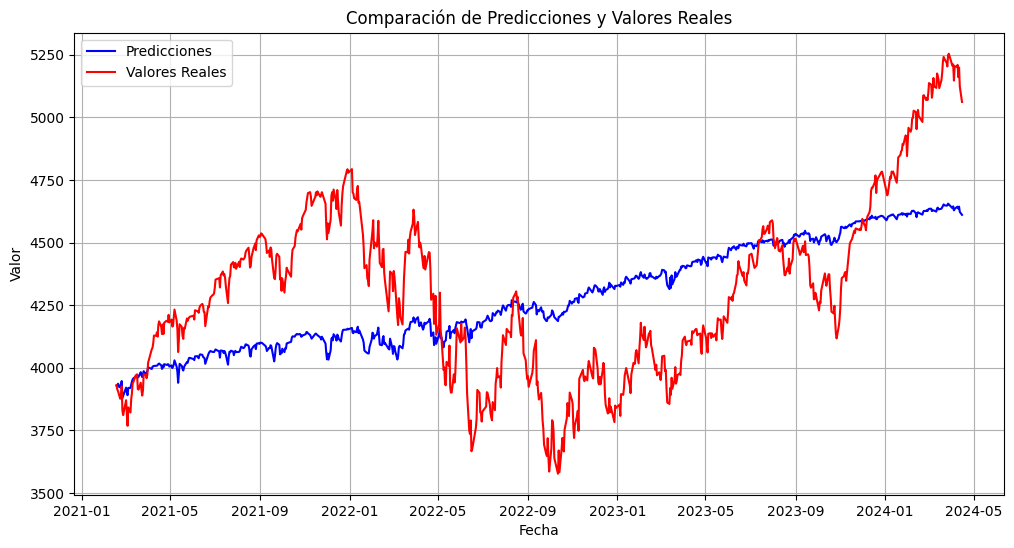

In [314]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las predicciones, asegurándote de usar el nombre correcto de la columna
plt.plot(predictions_arimax1_new_df.index, predictions_arimax1_new_df['Prediccion'], label='Predicciones', color='blue')

# Graficar los valores reales
plt.plot(y_test_arimax1_new_df.index, y_test_arimax1_new_df['Close'], label='Valores Reales', color='red')

# Añadir título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()

# Añadir cuadrícula
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [334]:
sp500_ARIMA_DR= sp500_ARIMA.copy()
sp500_ARIMA_DR['Retornos_Diarios'] = sp500_ARIMA_DR['Close'].pct_change() * 100  # Multiplicado por 100 para obtener el porcentaje

# Para ver los primeros 5 retornos
print(sp500_ARIMA_DR['Retornos_Diarios'].head())

missing_values = sp500_ARIMA_DR.isnull().sum()
print(missing_values)


Date
2008-06-04         NaN
2008-06-05    1.949615
2008-06-06   -3.088921
2008-06-09    0.079369
2008-06-10   -0.243807
Name: Retornos_Diarios, dtype: float64
Close               0
Retornos_Diarios    1
dtype: int64


In [335]:
# Eliminar filas que contengan valores nulos
sp500_ARIMA_DR_cleaned = sp500_ARIMA_DR.dropna()

# Verifica de nuevo si hay valores nulos
missing_values_cleaned = sp500_ARIMA_DR_cleaned.isnull().sum()
print(missing_values_cleaned)


Close               0
Retornos_Diarios    0
dtype: int64


In [339]:
# Divide los datos en conjuntos de entrenamiento y prueba (por ejemplo, 80% train, 20% test)
train_size_DR = int(len(sp500_ARIMA_DR_cleaned) * 0.8)
train_data_DR = sp500_ARIMA_DR_cleaned['Retornos_Diarios'][:train_size_DR]
test_data_DR = sp500_ARIMA_DR_cleaned['Retornos_Diarios'][train_size_DR:]

In [340]:
import pmdarima as pm
# Entrena el modelo ARIMA en el conjunto de entrenamiento
model_DR = pm.auto_arima(train_data_DR, seasonal=False, trace=True,
                      error_action='ignore', suppress_warnings=True,
                      stepwise=True)

# Guardar el modelo en un archivo binario
with open('model_arima_DR.pkl', 'wb') as pkl:
    pickle.dump(model_DR, pkl)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10810.461, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10877.430, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=10808.809, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10808.861, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10810.190, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10810.346, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=10804.570, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=10804.899, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=10812.118, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=10809.845, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=10788.737, Time=2.14 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=10806.508, Time=1.63 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=10790.747, Time=2.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=10789.642, Time=1.74 sec
 ARIMA(4,0,1)(0,0,0

In [341]:
# Hacer predicciones para el conjunto de prueba
predictions_DR = model_DR.predict(n_periods=len(test_data_DR))


c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lgarn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [342]:
# Calcula el MSE y el RMSE
mse = mean_squared_error(test_data_DR, predictions_DR)
rmse = np.sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MSE: 1.1710120084862914
RMSE: 1.0821330826133593


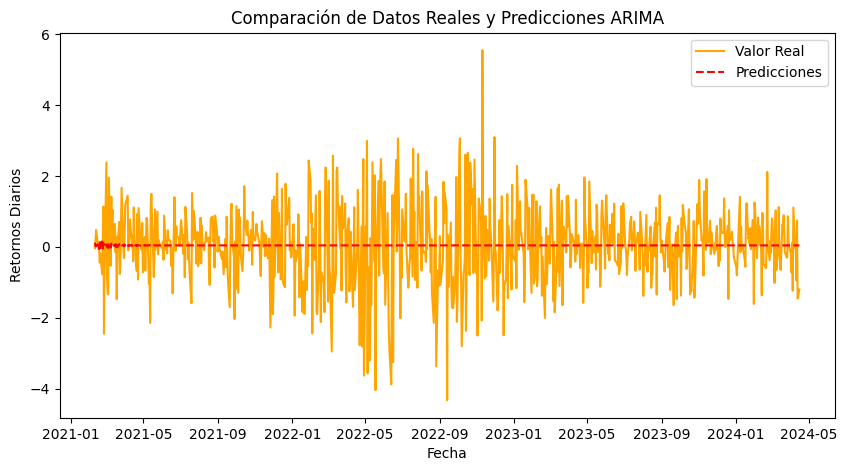

In [344]:
# Grafica los valores reales contra las predicciones
plt.figure(figsize=(10, 5))
#plt.plot(train_data_DR.index, train_data_DR, color='blue', label='Datos de Entrenamiento')
plt.plot(test_data_DR.index, test_data_DR, color='orange', label='Valor Real')
plt.plot(test_data_DR.index, predictions_DR, color='red', linestyle='--', label='Predicciones')
plt.title('Comparación de Datos Reales y Predicciones ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Retornos Diarios')
plt.legend()
plt.show()


ANÁLISIS DE LA SERIE HISTORICA

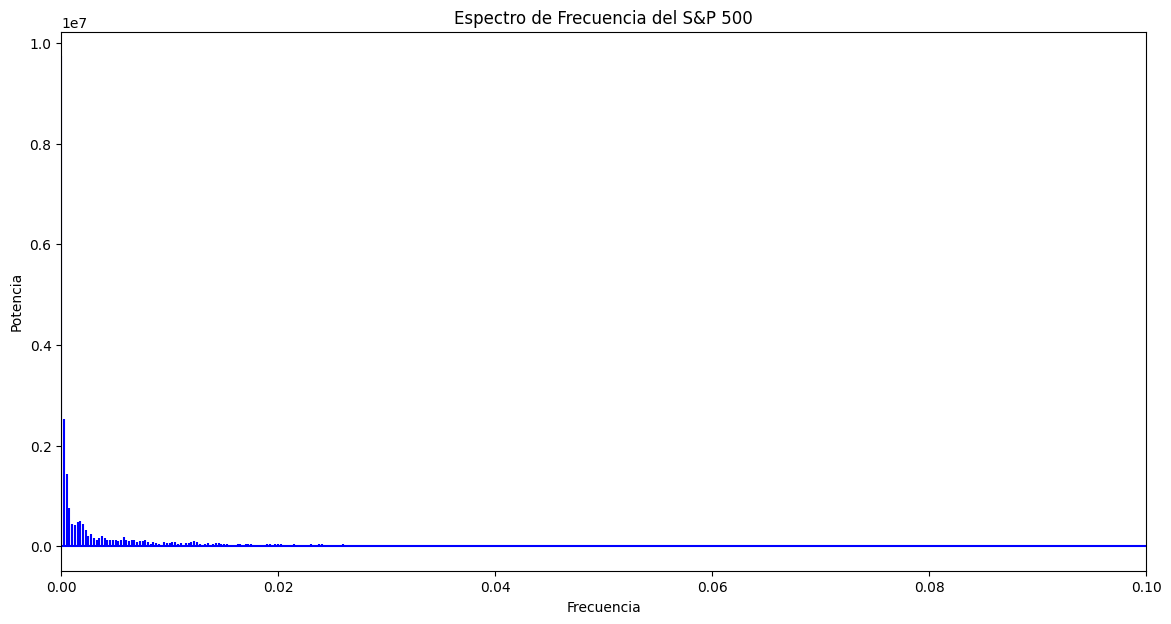

In [441]:

#Análisis de Fourier para determinar si existe estacionalidad
# Asumiendo que sp500_ARIMA es tu DataFrame y 'Close' es la columna con los precios de cierre
datos_sp500 = sp500_ARIMA['Close'].values



# Aplicar la Transformada de Fourier a los datos
fft_result = np.fft.fft(datos_sp500)

# Obtener las frecuencias asociadas
frecuencias = np.fft.fftfreq(datos_sp500.size, d=1)  # Ajusta 'd' según tu frecuencia de datos

# Calcular la potencia de la señal (magnitud del FFT)
potencia = np.abs(fft_result)

# Visualizar el Espectro de Frecuencia
plt.figure(figsize=(14, 7))
plt.stem(frecuencias, potencia, 'b', markerfmt=" ", basefmt="-b")
plt.xlim(0, 0.1)  # Ajusta este rango para enfocarte en las frecuencias bajas y ver mejor los picos
plt.title('Espectro de Frecuencia del S&P 500')
plt.xlabel('Frecuencia')
plt.ylabel('Potencia')
plt.show()


Pico dominante cerca de la frecuencia cero: Este pico grande e inmediato sugiere una fuerte tendencia general en los datos, lo que es esperado en datos financieros debido a la tendencia a largo plazo del mercado (como el crecimiento general del S&P 500 a lo largo de los años).

Disminución rápida en la potencia a medida que aumenta la frecuencia: Después del pico inicial, parece haber una caída muy pronunciada en la potencia a medida que te mueves hacia la derecha en el gráfico, lo que significa que no hay otras frecuencias con una magnitud significativa que contribuyan a la serie temporal. Esto indica que no hay otros ciclos periódicos fuertes y claros aparte de la tendencia general.

Potencia relativamente baja para las frecuencias mayores a cero: No parece haber picos significativos más allá del inicial, lo cual sugiere que no hay estacionalidades fuertes y claras a lo largo del año (como trimestrales o mensuales) que sean consistentemente prominentes en los datos del S&P 500. La serie temporal puede contener ruido o movimientos más aleatorios y menos predecibles que no están ligados a un ciclo estacional específico.

In [443]:
datos_sp500_2 = sp500_ARIMA[['Close']].copy()

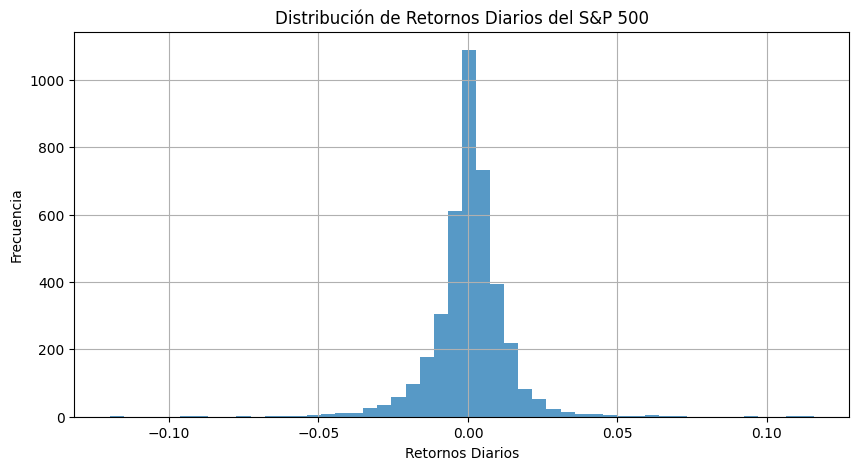

In [444]:
# Calcular los retornos diarios (porcentaje de cambio en el precio de cierre)
datos_sp500_2['Daily Returns'] = datos_sp500_2['Close'].pct_change()

# Crear el histograma de los retornos diarios
plt.figure(figsize=[10,5])
plt.hist(datos_sp500_2['Daily Returns'].dropna(), bins=50, alpha=0.75)
plt.title('Distribución de Retornos Diarios del S&P 500')
plt.xlabel('Retornos Diarios')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [ ]:
#Este histograma indica que los retornos diarios del S&P 500 siguen una distribución normal y que la mayoría de los retornos diarios están cerca de cero, es decir, que son pequeños. 
#El patrón cumple con lo que se conoce como market noise donde las fluctuaciones del dia a dia no son significativas.

La mayoría de los retornos diarios parecen agruparse alrededor del centro del histograma, cerca de cero, lo cual es típico para los retornos de índices de mercado en periodos cortos.
La distribución parece ser más o menos simétrica alrededor del pico central, lo que sugiere que los días con ganancias y pérdidas son, en promedio, igualmente comunes y que no hay un sesgo significativo hacia retornos positivos o negativos.

In [446]:
import statsmodels.api as sm

# Realizar la prueba de Dickey-Fuller Aumentada en los retornos diarios
# Eliminar valores NaN que resultan del cálculo de los retornos
daily_returns = datos_sp500_2['Daily Returns'].dropna()

result = sm.tsa.adfuller(daily_returns)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -15.740101
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Estadístico ADF (-15.707807): Este valor es bastante negativo, mucho más allá de los valores críticos dados para los diferentes niveles de confianza. Un estadístico tan negativo sugiere una fuerte evidencia estadística contra la hipótesis nula de que la serie tiene una raíz unitaria.
Valor p (0.000000): El valor p es esencialmente 0, lo que indica que puedes rechazar la hipótesis nula con un nivel de confianza extremadamente alto. Esto significa que es muy improbable que los resultados observados se deban al azar.
Valores Críticos:
1%: -3.432
5%: -2.862
10%: -2.567
Dado que tu estadístico ADF de -15.707807 es mucho menor que todos estos valores críticos, puedes rechazar la hipótesis nula con un nivel de confianza superior al 99%. Esto sugiere que los retornos diarios del S&P 500 no siguen una caminata aleatoria.
Conclusión
Los retornos diarios del S&P 500, según los datos que has analizado, muestran evidencia estadística de no ser una caminata aleatoria. Esto implica que existe algún grado de predictibilidad o patrón en la serie temporal de los retornos, lo que puede ser de interés para estrategias de inversión o análisis económico más detallado.

Estos resultados son importantes para la modelación de series temporales y pueden influir en cómo se modelan y predicen los movimientos futuros del mercado.








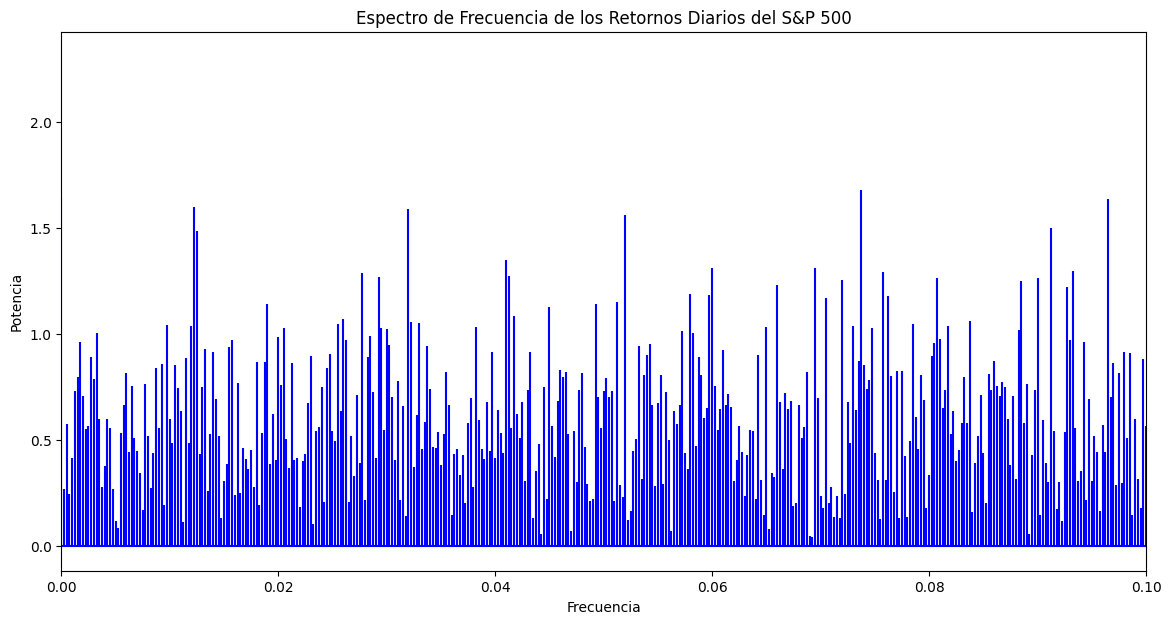

In [447]:


# Asumiendo que sp500_ARIMA es tu DataFrame y 'Close' es la columna con los precios de cierre
# Calcular los retornos diarios
retornos_diarios = sp500_ARIMA['Close'].pct_change().dropna().values

# Aplicar la Transformada de Fourier a los retornos diarios
fft_result = np.fft.fft(retornos_diarios)

# Obtener las frecuencias asociadas
frecuencias = np.fft.fftfreq(retornos_diarios.size, d=1)  # 'd=1' si los datos son diarios

# Calcular la potencia de la señal (magnitud del FFT)
potencia = np.abs(fft_result)

# Visualizar el Espectro de Frecuencia
plt.figure(figsize=(14, 7))
plt.stem(frecuencias, potencia, 'b', markerfmt=" ", basefmt="-b")
plt.xlim(0, 0.1)  # Ajusta este rango para enfocarte en las frecuencias bajas y ver mejor los picos
plt.title('Espectro de Frecuencia de los Retornos Diarios del S&P 500')
plt.xlabel('Frecuencia')
plt.ylabel('Potencia')
plt.show()


Ausencia de Picos Distintos: No hay picos destacados que sobresalgan significativamente por encima de los demás, lo que sugiere que no hay una estacionalidad clara y fuerte en los retornos diarios del S&P 500. Esto es común en los datos financieros, donde los retornos diarios están influenciados por una multitud de factores impredecibles y a menudo no presentan patrones estacionales claros.

Ruido a lo largo de las Frecuencias: La presencia de fluctuaciones a lo largo de todas las frecuencias con una magnitud relativamente estable podría ser indicativa de la naturaleza aleatoria o del "ruido blanco" en los retornos diarios.

Variabilidad Aleatoria: El hecho de que no haya picos claramente definidos podría indicar que los retornos diarios son en gran parte aleatorios y no están dominados por ciclos estacionales regulares.

Para concluir, la falta de patrones claros en este espectro de frecuencia sugiere que los retornos diarios del S&P 500 desde el año 2000 no están fuertemente influenciados por la estacionalidad a nivel diario. Esto no excluye la posibilidad de que existan tendencias o patrones en escalas de tiempo más largas, o que eventos específicos puedan causar perturbaciones significativas en el mercado, pero estos no parecen manifestarse como estacionalidad regular en los retornos diarios.

ARIMA modificado para incluir los valores históricos que van ocurriendo conforme pasa el tiempo (replica la realidad de que a la hora de invertir sabes los datos reales del pasado) --- POR ARREGLAR O ACLARAR PREGUNTA AL TUTOR

In [493]:
# Asumiendo que sp500_ARIMA es tu DataFrame y ya está definido

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size_arima2 = int(len(sp500_ARIMA) * 0.8)
train_arima2, test_arima2 = sp500_ARIMA['Close'][:train_size_arima2], sp500_ARIMA['Close'][train_size_arima2:]

# Ajustar el modelo AutoARIMA
model_returns_arima2 = auto_arima(train_arima2, seasonal=False, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True)

# Guardar el modelo
pickle.dump(model_returns_arima2, open('ARIMA2_Close_best_model_returns.pkl', 'wb'))
print("Mejor modelo ARIMA2 guardado:")
print(model_returns_arima2.summary())

# Actualizar el modelo y realizar predicciones en el conjunto de prueba
predicted_values_arima2 = []  # Lista para almacenar las predicciones
for new_val in test_arima2:
    model_arima2 = pickle.load(open('ARIMA2_Close_best_model_returns.pkl', 'rb'))  # Cargar el modelo
    model_arima2.update(new_val)  # Actualizar el modelo con el último valor real
    pred_arima2 = model_arima2.predict(n_periods=1)[0]  # Realizar la predicción para el próximo día
    predicted_values_arima2.append(pred_arima2)  # Almacenar la predicción

# Convertir la lista de predicciones a un array para cálculo de errores
predicted_values_array_arima2 = np.array(predicted_values_arima2)

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse_test_arima2 = mean_squared_error(test_arima2, predicted_values_array_arima2)
rmse_test_arima2 = np.sqrt(mse_test_arima2)
mae_test_arima2 = mean_absolute_error(test_arima2, predicted_values_array_arima2)

print(f'ARIMA2 Test - MSE: {mse_test_arima2}, RMSE: {rmse_test_arima2}, MAE: {mae_test_arima2}')

# Crear y guardar DataFrames
test_df_arima2 = pd.DataFrame({'Fecha': pd.to_datetime(sp500_ARIMA.index[train_size_arima2:]), 'Valor_Real': test_arima2, 'Prediccion': predicted_values_array_arima2})
test_df_arima2.to_csv('ARIMA2_test_vs_predicciones.csv', index=False)

valores_reales_df_arima2 = test_df_arima2[['Fecha', 'Valor_Real']]
valores_reales_df_arima2.to_csv('ARIMA2_valores_reales_test.csv', index=False)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29464.285, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29591.287, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29490.499, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29507.420, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29592.581, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29465.740, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29471.193, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29347.728, Time=1.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29397.011, Time=1.35 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=29392.398, Time=2.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29455.918, Time=2.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29458.295, Time=2.15 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=29389.516, Time=2.07 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=29351.164, Time=2.90 sec
 ARIMA(3,1,2)(0,0,0

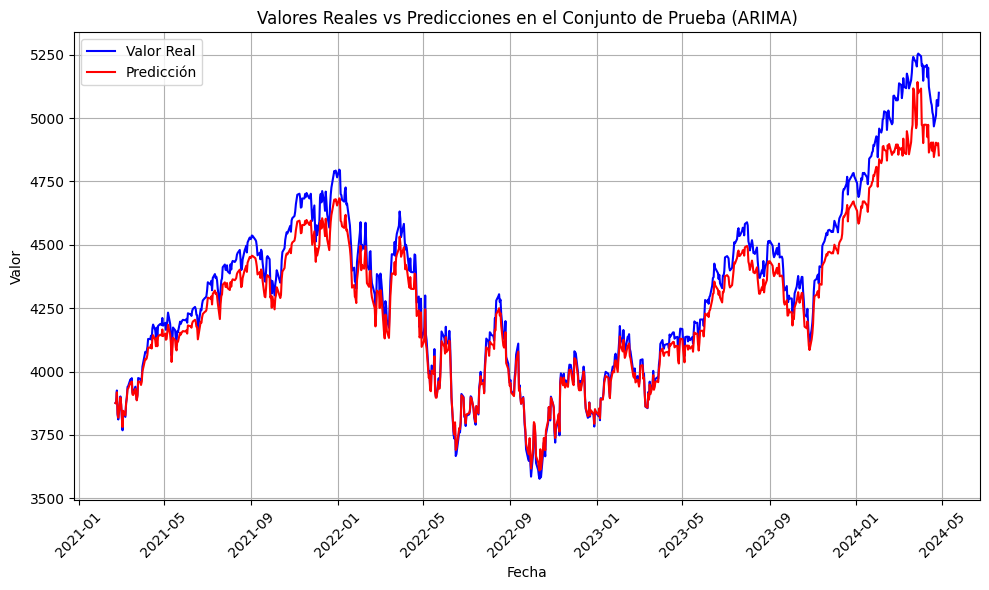

In [494]:
import matplotlib.pyplot as plt

# Graficar los valores reales y las predicciones
plt.figure(figsize=(10, 6))
plt.plot(test_df_arima2['Fecha'], test_df_arima2['Valor_Real'], label='Valor Real', color='blue')
plt.plot(test_df_arima2['Fecha'], test_df_arima2['Prediccion'], label='Predicción', color='red')
plt.title('Valores Reales vs Predicciones en el Conjunto de Prueba (ARIMA)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Guardar la gráfica
plt.savefig('ARIMA2_predicciones_vs_valores_reales.png')

# Mostrar la gráfica
plt.show()
